In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.ensemble import *
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [2]:
df_train = pd.read_csv('train.csv')
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [3]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing..

0

In [4]:
y = df_train['SalePrice']
X = df_train.iloc[:,0:62]

In [5]:
from sklearn.preprocessing import LabelEncoder
for column in X.columns:
    if X[column].dtype == type(object):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])

In [6]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.791069
GrLivArea        0.708618
GarageCars       0.640473
GarageArea       0.623423
TotalBsmtSF      0.613905
1stFlrSF         0.605968
FullBath         0.560881
TotRmsAbvGrd     0.533779
YearBuilt        0.523273
YearRemodAdd     0.507430
Fireplaces       0.466968
BsmtFinSF1       0.386436
WoodDeckSF       0.324422
2ndFlrSF         0.319464
OpenPorchSF      0.315831
HalfBath         0.284400
LotArea          0.263837
BsmtFullBath     0.227082
BsmtUnfSF        0.214446
BedroomAbvGr     0.168235
ScreenPorch      0.111419
PoolArea         0.092397
MoSold           0.046380
3SsnPorch        0.044571
BsmtFinSF2      -0.011412
BsmtHalfBath    -0.016873
MiscVal         -0.021200
Id              -0.021756
LowQualFinSF    -0.025620
YrSold          -0.028907
OverallCond     -0.077924
MSSubClass      -0.084230
EnclosedPorch   -0.128627
KitchenAbvGr    -0.135935
Name: SalePrice, dtype: float64


In [7]:
clf = RandomForestRegressor(n_estimators=1000)
clf = clf.fit(X, y)
#clf.feature_importances_

In [8]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

X_new.shape

(1459, 8)

In [9]:
selected_feat= X.columns[(model.get_support())]
selected_feat

Index(['OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'GarageCars', 'GarageArea'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
X_train.shape

(977, 8)

In [11]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [12]:
# Define error measure for official scoring : RMSE
scorerR2 = make_scorer(r2_score)

def r2score_cv_train(model):
    rmse= cross_val_score(model, X_train, y_train, scoring = scorerR2, cv = 10)
    return(rmse)

def r2score_cv_test(model):
    rmse= cross_val_score(model, X_test, y_test, scoring = scorerR2, cv = 10)
    return(rmse)

In [13]:
est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

In [14]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(est).mean())
print("RMSE on Test set :", rmse_cv_test(est).mean())

RMSE on Training set : 35361.41922626227
RMSE on Test set : 31063.64916840409


In [15]:
# Look at predictions on training and validation set
print("R^2 score on Training set :", r2score_cv_train(est).mean())
print("R^2 score on Test set :", r2score_cv_test(est).mean())

R^2 score on Training set : 0.7714960815375671
R^2 score on Test set : 0.8527375431460609


In [20]:
clf = AdaBoostClassifier(n_estimators=100)

In [21]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(clf).mean())
print("RMSE on Test set :", rmse_cv_test(clf).mean())

RMSE on Training set : 41664.1495885836
RMSE on Test set : 30759.163621757703


In [22]:
# Look at predictions on training and validation set
print("R^2 score on Training set :", r2score_cv_train(clf).mean())
print("R^2 score on Test set :", r2score_cv_test(clf).mean())

R^2 score on Training set : -0.452880532441544
R^2 score on Test set : 0.21950123246200376


In [16]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

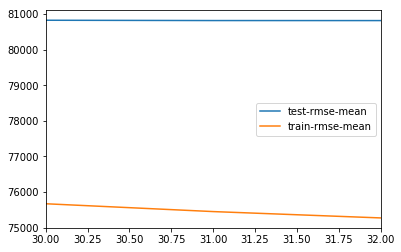

In [17]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [18]:
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv

In [19]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(model_xgb).mean())
print("RMSE on Test set :", rmse_cv_test(model_xgb).mean())

RMSE on Training set : 34373.65564114222
RMSE on Test set : 30318.117384061166


In [20]:
# Look at predictions on training and validation set
print("R^2 score on Training set :", r2score_cv_train(model_xgb).mean())
print("R^2 score on Test set :", r2score_cv_test(model_xgb).mean())

R^2 score on Training set : 0.7821995592455978
R^2 score on Test set : 0.8558291642614508
